In [16]:
# Проверка результативности массивов xgbooster (2017-07-03)

In [17]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [18]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [19]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [20]:
import xgboost as xgb

In [21]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [22]:
binsData = 96

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trWork, teWork = '../Work/Train', '../Work/Test'
print (trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [23]:
binsDataTIF = 96
binsDataJPG = 96

In [24]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [25]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [26]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [27]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [28]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [29]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,0])

NameError: name 'trX' is not defined

In [30]:
# Построение списка bst - моделей
def getListBST (param, trX, trY, nfold=3, early_stop=20) :
    dtrain = xgb.DMatrix(trX,label=trY[:,0])
    results, bstList = [], []
    for i in range(trY.shape[1]) :
        print ('Working: {}'.format(i))
        dtrain.set_label(trY[:,i])
        history = xgb.cv(param, dtrain, metrics=['auc'], 
                         verbose_eval=30, num_boost_round=5000, nfold=nfold, 
                         early_stopping_rounds=early_stop)
        results.append(history)
        rvalidCV, watchlistCV = {}, [(dtrain,'train')]
        bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
        bstList.append(bst)
    return(bstList)

# Построение решения по dmatrix и bst списку
def buildPredict (dData, bstList) :
    trYP = []
    for bstI in bstList :
        trYP1 = bstI.predict(dData); trYP.append(trYP1)
    trYP = np.array(trYP).T
    #type(trYP),trYP.shape
    return(trYP)

# Построение решения по np.array (DataFrame?) и bst списку
def buildPredictX (Data, bstList) :
    dData = xgb.DMatrix(Data);
    return (buildPredict(dData,bstList))

In [31]:
# Процедуры для оценки результативности

def getConfusion (tGroundTrue, tPredict) :
    cList = []
    for i in range(tPredict.shape[1]) :
        cList.append(skm.confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(cList))

def getRocAUC (tGroundTrue, tPredict) :
    rList = []
    for i in range(tPredict.shape[1]) :
        rList.append(skm.roc_auc_score(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(rList))

In [32]:
# Построение пределов прохождения для предсказанного
def getTh (tGround,tPredict, prec=100 ) :
    ixx,iacc = [], []
    for i in range(tGround.shape[1]) :
        max, maxxx = 0.0, 0.0
        for xx in range(0,prec+1) :
            tempYP = getProb01(tPredict[:,i],th=(float(xx)/prec)); #print(tPredict[:,1],tempYP[0])
            temp = skm.accuracy_score(tGround[:,i],tempYP)
            #print(float(xx/10.0),temp)
            if (temp>max) : 
                max = temp; maxxx = float(xx)
                temp = skm.confusion_matrix(tGround[:,i],tempYP);
                minloss = temp[0][1]+temp[1][0]
        ixx.append(maxxx)
        tempYP = getProb01 (tPredict[:,i])
        temp = skm.accuracy_score(tGround[:,i],tempYP)
        minloss05 = skm.confusion_matrix(tGround[:,i],tempYP);
        minloss05 = minloss05[0][1]+minloss05[1][0]
        iacc.append((maxxx,max,temp,minloss,minloss05))
    ixx = [float(xx/prec) for xx in ixx]
    return (ixx,iacc)
#ixx, iacc = getTh(trY,trYPP, prec=100)
#np.array(ixx) , iacc

In [33]:
# Оценка нескольких наборов
def getProb01 (trYP, th=0.5) :
    trYY = trYP.copy()
    trYY[trYY<th] = 0
    trYY[trYY>0]  = 1
    return (trYY)

def estimateTrain (estimateList, param) :
    res = []
    for jpgtif, bins in estimateList :
        #trX     = np.load('../Work/train-data-XX'+str(bins)+jpgtif+'.npy')
        #trY     = np.load('../Work/train-data-YY'+str(bins)+jpgtif+'.npy')
        trX     = np.load('../Work/t-'+str(10000+bins)+jpgtif+'-XX-train.npy')
        trY     = np.load('../Work/t-'+str(10000+bins)+jpgtif+'-YY-train.npy')
        listBST = getListBST(param, trX, trY)
        trYP    = buildPredictX(trX,listBST)
        trYY    = getProb01(trYP)
        res.append(np.array(getConfusion(trY,trYY)))
    return(res)      

In [34]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

In [35]:
xJPG = estimateTrain([('.jpg',256),('.jpg',128),('.jpg',96)],param)
%time

Working: 0
[0]	train-auc:0.943547+0.00524291	test-auc:0.929328+0.00505594
[30]	train-auc:0.988459+0.000516729	test-auc:0.958506+0.00232698
[60]	train-auc:0.996101+0.000172513	test-auc:0.958487+0.0025079
[0]	train-auc:0.943299	train-rmse:0.377534
[1]	train-auc:0.948933	train-rmse:0.300219
[2]	train-auc:0.958053	train-rmse:0.250566
[3]	train-auc:0.9606	train-rmse:0.220209
[4]	train-auc:0.963582	train-rmse:0.201258
[5]	train-auc:0.966638	train-rmse:0.189529
[6]	train-auc:0.968566	train-rmse:0.182326
[7]	train-auc:0.969726	train-rmse:0.177749
[8]	train-auc:0.970854	train-rmse:0.175135
[9]	train-auc:0.972179	train-rmse:0.172977
[10]	train-auc:0.973048	train-rmse:0.171026
[11]	train-auc:0.974115	train-rmse:0.170041
[12]	train-auc:0.97567	train-rmse:0.168424
[13]	train-auc:0.976395	train-rmse:0.167968
[14]	train-auc:0.977073	train-rmse:0.167384
[15]	train-auc:0.977724	train-rmse:0.16678
[16]	train-auc:0.978741	train-rmse:0.165077
[17]	train-auc:0.979507	train-rmse:0.163399
[18]	train-auc:0.97

In [36]:
#xJPG
for cms in xJPG :
    cm = cms[:,0,1]+cms[:,1,0]
    print (cm.sum(),cms[:,0,1]+cms[:,1,0])
%time

14885 [1149   38 2821  338 3083  431 2639 3334    9  205    0    0  524    0  212
   92   10]
14488 [ 946   95 3482  532  395 1479 3180 3275   81   42    0    0  463    0  278
  211   29]
17857 [1087  153 3360  776 2192 1495 3837 3323  194    0  470    2  493    0  229
  243    3]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


In [64]:
#xJPG
for cms in xJPG :
    cm = cms[:,0,1]+cms[:,1,0]
    print (cm.sum(),cms[:,0,1]+cms[:,1,0])
%time

19743 [1224  629 3295  576 4277 1799 2939 3338  206   13  408    0  433   13  234
  324   35]
18538 [1248   90 3625 1106 2927 1603 3518 2655  194   38  233    0  658    0  264
  303   76]
15592 [1338  470 2304  551 2569 1136 3111 2691  168  143   18   24  532    0  269
  227   41]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [72]:
#xTIF = estimateTrain([('.tif',32),('.tif',64),('.tif',96)],param)
%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [66]:
for cms in xTIF :
    cm = cms[:,0,1]+cms[:,1,0]
    print (cm.sum(),cms[:,0,1]+cms[:,1,0])
%time

23842 [1438 1001 3107 1913 3395 1967 4088 3460  188  413 1761   17  492    6  197
  301   98]
21119 [1015  864 3257  846 3520 1771 3654 3382  149  369  994   54  654    9  198
  304   79]
17984 [ 874  783 2743  732 3002 1824 3533 3074   57   99  146    0  658   24  303
   53   79]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


In [38]:
wr = [labels.index(i) for i in weather_labels]; wr
print(labels)
trYPP[trYPP[:,wr].argmax(axis=1)<>trY[:,wr].argmax(axis=1)].shape, wr, (40497.0-498)/40497.0, (40497.0-898)/40497.0

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


((549, 17), [3, 10, 0, 9], 0.9877027927994666, 0.9778255179396005)

In [39]:
# Построение значимости полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

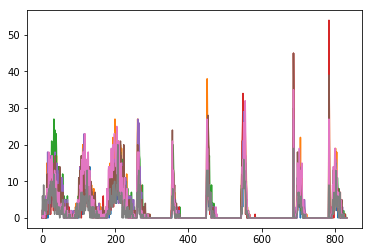

['haze',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'bare_ground']

In [40]:
xx = [0]+range(2,8)+[12] # плохие 600-4000
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


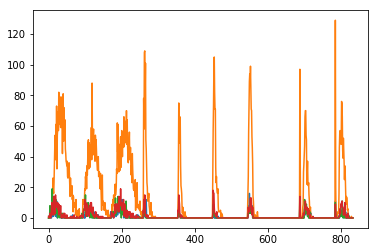

['slash_burn', 'partly_cloudy', 'blooming', 'selective_logging']

In [41]:
xx = [8,10,14,15] # среднии 100-400
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


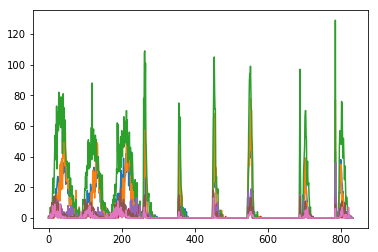

['primary',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'artisinal_mine',
 'selective_logging',
 'blow_down']

In [55]:
xx = [1,9,10,11,13,15,16] # отличные 0-100
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [56]:
# Посчитать уровень прохождения для каждого признака
ixx, iacc = getTh(trY,trYPP)
np.array(ixx), iacc

(array([ 0.39,  0.42,  0.46,  0.54,  0.4 ,  0.35,  0.44,  0.35,  0.19,
         0.25,  0.08,  0.08,  0.24,  0.1 ,  0.19,  0.22,  0.14]),
 [(39.0, 0.97872971170236422, 0.97769213666345511, 861, 903),
  (42.0, 0.99997529583240696, 0.99997529583240696, 1, 1),
  (46.0, 0.94021591442476349, 0.93851132686084138, 2420, 2489),
  (54.0, 0.97490056572543793, 0.974282961535611, 1016, 1041),
  (40.0, 0.93611502260431334, 0.93260703080609697, 2586, 2728),
  (35.0, 0.98085427011536841, 0.97643222411620845, 775, 954),
  (44.0, 0.9399194644136466, 0.93653499345339564, 2432, 2569),
  (35.0, 0.9494058647693866, 0.93962301440252971, 2048, 2444),
  (19.0, 0.99945650831295241, 0.99752958324069274, 22, 100),
  (25.0, 1.0, 1.0, 0, 0),
  (8.0, 1.0, 1.0, 0, 0),
  (8.0, 1.0, 1.0, 0, 0),
  (24.0, 0.99041478297388774, 0.98715383285160208, 388, 520),
  (10.0, 1.0, 1.0, 0, 0),
  (19.0, 0.99622026235825989, 0.99407099977766245, 153, 240),
  (22.0, 0.999332987474987, 0.99770251241384422, 27, 93),
  (14.0, 0.999654141

In [57]:
# Forming output dataset for predicting --> trOX, trOY
#del(trX)
#del(trY)

In [58]:
# Данные для объединения от jpg
##trOX_JPG1 = np.load('../Work/test-data-XX'+str(binsDataJPG)+'.jpg'+'.npy')
##trOX_JPG2 = np.load('../Work/test-data-XX'+str(binsDataJPG2)+'.jpg'+'.npy')
trOX_JPG  = np.load('../Work/test-data-XX'+str(binsDataJPG)+'.jpg'+'.npy')
trOX_TIF  = np.load('../Work/test-data-XX'+str(binsDataTIF)+'.tif'+'.npy')
trOY_TIF  = np.load('../Work/test-data-YY'+str(binsDataTIF)+'.tif'+'.npy')
#trOY_JPG1 = np.load('../Work/test-data-YY'+str(binsDataJPG)+'.jpg'+'.npy')
#trOY_JPG2 = np.load('../Work/test-data-YY'+str(binsDataJPG2)+'.jpg'+'.npy')
trOY_JPG = np.load('../Work/test-data-YY'+str(binsDataJPG)+'.jpg'+'.npy')

In [59]:
#trOX_TIF.shape, trOX_JPG.shape, trOX_JPG2.shape , 578+255+192
trOX_TIF.shape, trOX_JPG.shape , 578+255+192

((61191, 578), (61191, 255), 1025)

In [60]:
# Обрезка видимой части и использование только n, nvi, dwi
##trOX_TIF = trOX_TIF[:,288:]
##trOX_TIF.shape

In [61]:
# Аккуратно объединяем через индексы = имена файлов
dfOX_TIF  = pd.DataFrame(trOX_TIF,index=trOY_TIF)
##dfOX_JPG1 = pd.DataFrame(trOX_JPG,index=trOY_JPG1)
##dfOX_JPG2 = pd.DataFrame(trOX_JPG2,index=trOY_JPG2)
##dfOX_JPG  = dfOX_JPG1.join(dfOX_JPG2,lsuffix='_l',rsuffix='_r')

dfOX_JPG = pd.DataFrame(trOX_JPG,index=trOY_JPG)
dfOX     = dfOX_JPG.join(dfOX_TIF,lsuffix='_l',rsuffix='_r')

dfOX.shape #, dfOX.columns,dfOX.head()

(61191, 833)

In [62]:
trOX = dfOX.values
trOY = dfOX.index.values
trOX.shape,trOY.shape,trOY[0:10]

((61191, 833),
 (61191,),
 array(['test_10002', 'test_10003', 'test_10004', 'test_10005',
        'test_10006', 'test_10007', 'test_10008', 'test_10009', 'test_1001',
        'test_10010'], dtype=object))

In [63]:
# Формирование результата
dtest  = xgb.DMatrix(trOX)

In [64]:
trP = []
for bstI in bstList :
    trP1 = bstI.predict(dtest);
    trP.append(trP1)
trP = np.array(trP).T
type(trP),trP.shape    

(numpy.ndarray, (61191, 17))

In [65]:
#np.save('../Work/test-data-RR'+str(binsData)+ttExt+'.npy',trP)

In [66]:
#trP = np.load('../Work/test-data-RR'+str(binsData)+ttExt+'.npy')
#trP.shape

In [67]:
wr = [labels.index(i) for i in weather_labels];
trM=np.array(ixx) #np.array([0.5]*17);
#### Коэффициенты работают +0.01 к счету trM=np.array([0.5]*17);
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.42, 0.46, 2.0, 0.4, 0.35, 0.44, 0.35, 0.19, 2.0, 2.0, 0.08, 0.24, 0.1, 0.19, 0.22, 0.14]


In [68]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trA1 = [weather_labels[trP[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])]
    trPP = trA1 + trA2;
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.    0.42  0.46  2.    0.4   0.35  0.44  0.35  0.19  2.    2.    0.08
  0.24  0.1   0.19  0.22  0.14] [  4.30692956e-02   3.47555101e-01   6.04333766e-02   2.93665826e-01
   1.17301032e-01   2.01818300e-03   3.60038574e-03   1.09107210e-03
   2.75305702e-05   8.66805375e-01   3.23356013e-04   2.19742469e-05
   2.54213880e-03   2.35209177e-06   1.78975912e-04   2.23689625e-04
   1.82826421e-04]


In [69]:
print(labels)
print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.42, 0.46, 2.0, 0.4, 0.35, 0.44, 0.35, 0.19, 2.0, 2.0, 0.08, 0.24, 0.1, 0.19, 0.22, 0.14]


In [70]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-03-19-48-53
